In [1]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
def load_dataset(file_path, text_column, label_column):
    df = pd.read_csv(file_path)
    texts = df[text_column].values
    labels = df[label_column].values
    return texts, labels

In [3]:
def split_dataset(texts, labels, test_size=0.3, random_state=42):
    return train_test_split(texts, labels, test_size=test_size, random_state=random_state)

In [4]:
def tokenize_data(tokenizer, texts):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128, return_tensors='tf')
    return encodings['input_ids']

In [5]:
def build_model(pretrained_model_name, num_labels):
    model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_labels)
    return model

In [6]:
def compile_model(model, learning_rate=5e-5):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

In [7]:
def train_model(model, train_input_ids, train_labels, val_input_ids, val_labels, epochs=5, batch_size=32):
    history = model.fit(
        train_input_ids,
        train_labels,
        validation_data=(val_input_ids, val_labels),
        epochs=epochs,
        batch_size=batch_size
    )
    return history

In [8]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

In [10]:
def evaluate_on_train(model, train_input_ids, train_labels, class_names):
    y_pred_train = np.argmax(model.predict(train_input_ids)[0], axis=1)
    print("Training Classification Report:\n", classification_report(train_labels, y_pred_train))

    conf_matrix_train = confusion_matrix(train_labels, y_pred_train)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Training Confusion Matrix')
    plt.show()

    accuracy_train = accuracy_score(train_labels, y_pred_train)
    print(f"Training Accuracy: {accuracy_train * 100:.2f}%")
    return y_pred_train

In [9]:
def evaluate_model(model, input_ids, true_labels, class_names):
    y_pred = np.argmax(model.predict(input_ids)[0], axis=1)
    print("Classification Report:\n", classification_report(true_labels, y_pred))

    conf_matrix = confusion_matrix(true_labels, y_pred)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix (%)')
    plt.show()

    accuracy = accuracy_score(true_labels, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return y_pred


In [ ]:
def evaluate_model(model, input_ids, true_labels, class_names):
    y_pred = np.argmax(model.predict(input_ids)[0], axis=1)
    print("Classification Report:\n", classification_report(true_labels, y_pred))

    conf_matrix = confusion_matrix(true_labels, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(true_labels, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return y_pred

In [11]:
def save_predictions(texts, true_labels, predicted_labels, output_file):
    predictions_df = pd.DataFrame({
        'Text': texts,
        'True Label': true_labels,
        'Predicted Label': predicted_labels
    })
    predictions_df.to_csv(output_file, index=False)
    print(f"Predictions saved to '{output_file}'.")

In [12]:
def predict_on_new_data(saved_model_dir, new_test_file, text_column, output_file, max_length=128):
    model = TFAutoModelForSequenceClassification.from_pretrained(saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)

    new_test_data = pd.read_csv(new_test_file)
    if text_column not in new_test_data.columns:
        raise ValueError(f"Column '{text_column}' not found in the new test dataset.")

    new_test_texts = new_test_data[text_column].values
    new_test_encodings = tokenize_data(tokenizer, new_test_texts, max_length=max_length)

    logits = model.predict(new_test_encodings)[0]

    new_predictions = np.argmax(logits, axis=1)

    new_test_data['Class (Predicted Label)'] = new_predictions

    new_test_data.to_csv(output_file, index=False)
    print(f"New test predictions saved to '{output_file}'.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
132/132 [==============================] - 170s 969ms/step - loss: 0.6690 - accuracy: 0.7633 - val_loss: 0.3946 - val_accuracy: 0.8378
Epoch 2/5
132/132 [==============================] - 134s 1s/step - loss: 0.2723 - accuracy: 0.9100 - val_loss: 0.1264 - val_accuracy: 0.9633
Epoch 3/5
132/132 [==============================] - 134s 1s/step - loss: 0.0765 - accuracy: 0.9793 - val_loss: 0.0479 - val_accuracy: 0.9894
Epoch 4/5
132/132 [==============================] - 134s 1s/step - loss: 0.0303 - accuracy: 0.9926 - val_loss: 0.0575 - val_accuracy: 0.9833
Epoch 5/5
132/132 [==============================] - 134s 1s/step - loss: 0.0192 - accuracy: 0.9962 - val_loss: 0.0322 - val_accuracy: 0.9928


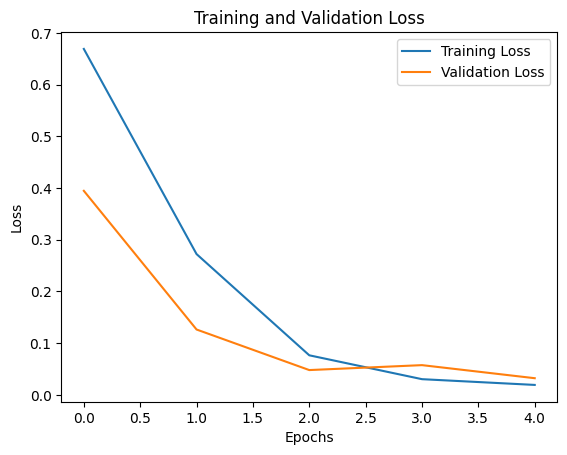

132/132 [==============================] - 41s 289ms/step
Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       253
           1       1.00      1.00      1.00      3196
           2       1.00      1.00      1.00       751

    accuracy                           1.00      4200
   macro avg       1.00      0.99      1.00      4200
weighted avg       1.00      1.00      1.00      4200



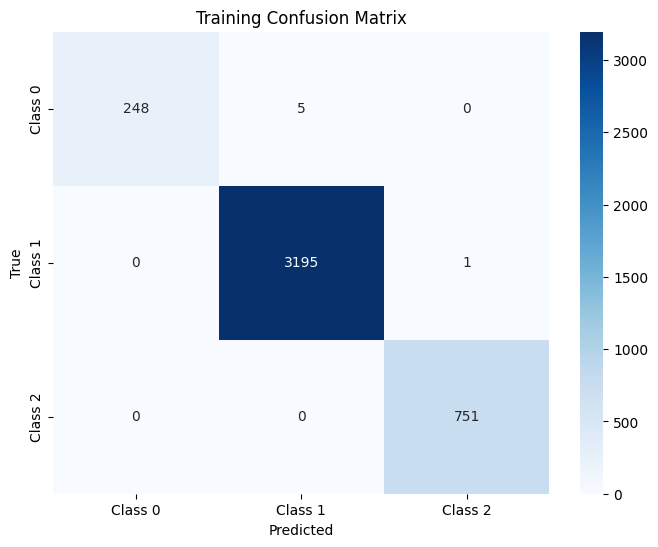

Training Accuracy: 99.86%
57/57 [==============================] - 16s 281ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        83
           1       1.00      0.99      1.00      1376
           2       0.97      1.00      0.99       341

    accuracy                           0.99      1800
   macro avg       0.98      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



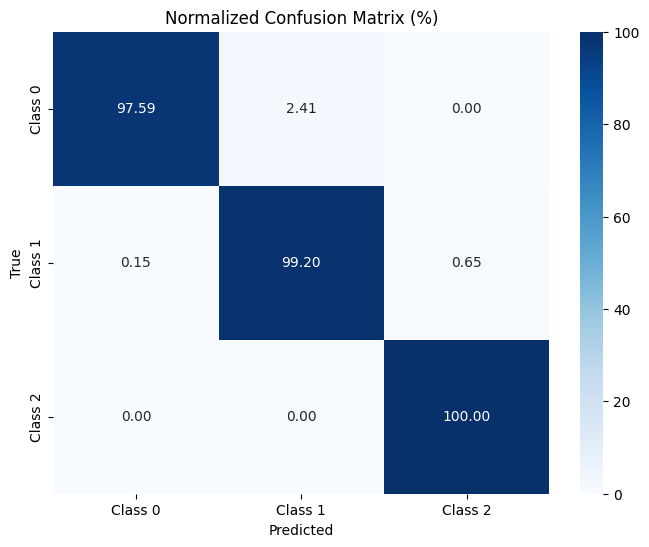

Accuracy: 99.28%


In [13]:
dataset_file = r"/content/augmented_data_3.csv"
output_predictions = "test_predictions.csv"

text_column = "corrected_tweet"
label_column = "class"

texts, labels = load_dataset(dataset_file, text_column, label_column)
X_train, X_test, y_train, y_test = split_dataset(texts, labels)

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
train_input_ids = tokenize_data(tokenizer, X_train)
test_input_ids = tokenize_data(tokenizer, X_test)

num_labels = len(set(labels))
model = build_model('bert-base-uncased', num_labels)
model = compile_model(model)

# model_save_dir = r"D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\nlp_models\fine_tuned_bert_with_augmented_dataset.h5"
# model.save_pretrained(model_save_dir)
# tokenizer.save_pretrained(model_save_dir)
# print(f"Model saved to '{model_save_dir}'")

history = train_model(model, train_input_ids, y_train, test_input_ids, y_test)
plot_loss(history)

class_names = ["Class 0", "Class 1", "Class 2"]
train_predictions = evaluate_on_train(model, train_input_ids, y_train, class_names)
y_pred = evaluate_model(model, test_input_ids, y_test, class_names)
#save_predictions(X_test, y_test, y_pred, output_predictions)



In [ ]:
test_file = r"D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\data\cleaned_dataset\labeled_data_cleaned_test.csv"
new_test_predictions = r"D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\data\cleaned_dataset\predictions_test.csv"
predict_on_new_data(model_save_dir, test_file, text_column, new_test_predictions)


Some layers from the model checkpoint at D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\nlp_models\fine_tuned_bert_with_normal_dataset.h5 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at D:\epita class notes\semester - 3\action learnign\project repository\Hate_s

32/32 [==============================] - 25s 682ms/step
New test predictions saved to 'D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\data\cleaned_dataset\predictions_test.csv'.
